# Initalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import datetime
from datetime import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#df = pd.read_csv('/content/aggregate_data.csv',  sep=';')
df = pd.read_csv('/content/drive/MyDrive/Master Thesis/aggregate_data.csv' ,  sep=';')
#we delete white spacesat the beginning and at the end of every columns for better handling
df.columns = df.columns.str.strip()
#we print the column names
df.columns

Index(['Company', 'Polarity', 'Subjectivity', 'Positive', 'Negative',
       'Neutral', 'Sentiment Score', 'Datapoints', 'Date',
       'Social Pillar Score', 'Sector'],
      dtype='object')

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=['Social Pillar Score']);
df.head()

,Company,Polarity,Subjectivity,Positive,Negative,Neutral,Sentiment Score,Datapoints,Date,Social Pillar Score,Sector
0,002385.SZ,0.172973,0.454505,1,0,0,0.586486,1,2022-12-31,30.348570,Food & Beverages
1,002714.SZ,-0.043750,0.743750,0,0,1,0.478125,1,2022-12-31,41.466436,Food & Beverages
2,007310.KS,0.021370,0.260431,1,0,3,0.510685,4,2022-12-31,30.216028,Food & Beverages
3,0220.HK,0.026984,0.058730,1,0,2,0.513492,3,2022-12-31,55.580220,Food & Beverages
4,0288.HK,0.159300,0.451427,4,0,0,0.579650,4,2022-12-31,81.418250,Food & Beverages


In [ ]:
df.shape[0]

414

# 1. Full Dataset Analysis


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Text(0.5, 1.0, 'Social Pillar Score in function of Sentiment Score (full Dataset)')

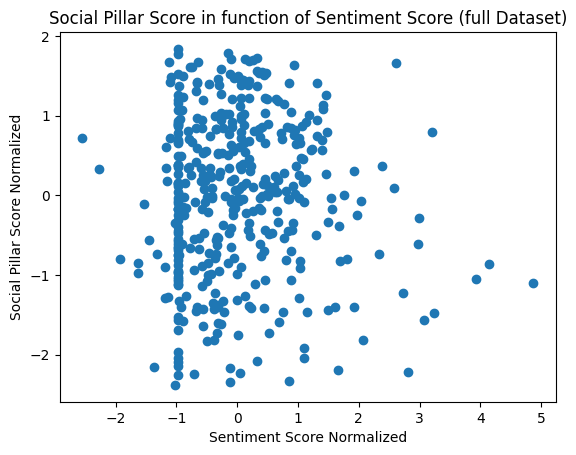

In [ ]:
# Normalization: (x-mean(x))/std(x)
df['Sentiment Score Normalized'] = (df[['Sentiment Score']] - np.mean(df[['Sentiment Score']]))/ np.std(df[['Sentiment Score']])
df['Social Pillar Score Normalized'] = (df[['Social Pillar Score']] - np.mean(df[['Social Pillar Score']]))/ np.std(df[['Social Pillar Score']])
plt.scatter(df['Sentiment Score Normalized'], df['Social Pillar Score Normalized'])
plt.xlabel('Sentiment Score Normalized')
plt.ylabel('Social Pillar Score Normalized')
plt.title('Social Pillar Score in function of Sentiment Score (full Dataset)')

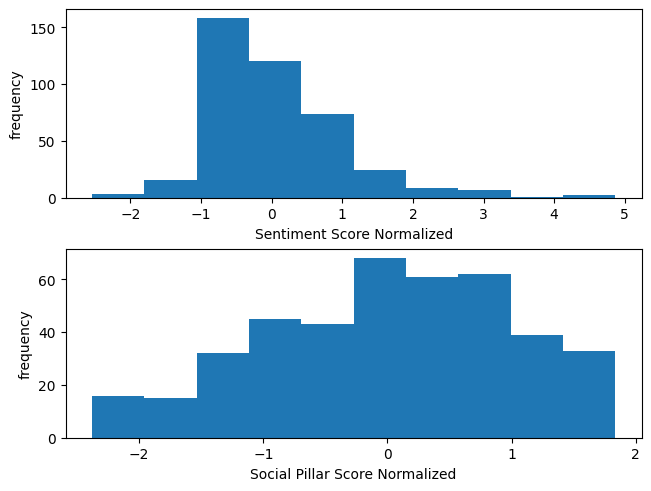

In [ ]:
#Distribution of the normalized Data
plt.figure(layout="constrained")
plt.subplot(2, 1, 1)
plt.ylabel('frequency')
plt.xlabel('Sentiment Score Normalized')
plt.hist(df['Sentiment Score Normalized'])
plt.subplot(2, 1, 2)
plt.ylabel('frequency')
plt.xlabel('Social Pillar Score Normalized')
plt.hist(df['Social Pillar Score Normalized'])
plt.show()

In [ ]:
# Sentiment Score Normal Test
normaltest = stats.normaltest(df['Sentiment Score Normalized']).statistic
pvalue = stats.normaltest(df['Sentiment Score Normalized']).pvalue
skew = stats.skew(df['Sentiment Score Normalized'], axis=0, bias=True)
kurtosis = stats.kurtosis(df['Sentiment Score Normalized'], axis=0, bias=True)
print('test normal: %f (pvalue=%f) , skewness: %f , kurtosis: %f' % (normaltest, pvalue, skew, kurtosis))

test normal: 96.188263 (pvalue=0.000000) , skewness: 1.205458 , kurtosis: 2.498051


In [ ]:
#Social Pillar Score Normal Test
normaltest = stats.normaltest(df['Social Pillar Score Normalized']).statistic
pvalue = stats.normaltest(df['Social Pillar Score Normalized']).pvalue
skew = stats.skew(df['Social Pillar Score Normalized'], axis=0, bias=True)
kurtosis = stats.kurtosis(df['Social Pillar Score Normalized'], axis=0, bias=True)
print('test normal: %f (pvalue=%f) , skewness: %f , kurtosis: %f' % (normaltest, pvalue, skew, kurtosis))

test normal: 22.704498 (pvalue=0.000012) , skewness: -0.300251 , kurtosis: -0.662827


In [ ]:
personstat = stats.pearsonr(df['Sentiment Score Normalized'], df['Social Pillar Score Normalized']).statistic
personpvalue = stats.pearsonr(df['Sentiment Score Normalized'], df['Social Pillar Score Normalized']).pvalue
kendalltaustat = stats.kendalltau(df['Sentiment Score Normalized'], df['Social Pillar Score Normalized']).statistic
kendalltauvalue = stats.kendalltau(df['Sentiment Score Normalized'], df['Social Pillar Score Normalized']).pvalue

print('Pearson R Test: %f (pvalue=%f) , Kendall Tau Test: %f (pvalue=%f) ' % (personstat, personpvalue, kendalltaustat, kendalltauvalue))

Pearson R Test: -0.021810 (pvalue=0.658144) , Kendall Tau Test: 0.039745 (pvalue=0.231490) 


In [ ]:
stats.spearmanr(df['Sentiment Score Normalized'], df['Social Pillar Score Normalized'])

SignificanceResult(statistic=0.06014628970519516, pvalue=0.22200969476936047)

In [ ]:
#check if our the Social Pillar Score is linked with the number of good and bad news
df["Negativity Ratio"] = df["Negative"]/df["Datapoints"]
df["Positivity Ratio"] = df["Positive"]/df["Datapoints"]
df["Neutral Ratio"] = 1-(df["Positivity Ratio"]+df["Negativity Ratio"])

df_neg = df[(df["Negativity Ratio"] > 0) & (df["Negativity Ratio"] < 1)]
df_pos = df[(df["Positivity Ratio"] > 0) & (df["Positivity Ratio"] < 1)]
df_neu = df[(df["Neutral Ratio"] > 0) & (df["Neutral Ratio"] < 1)]

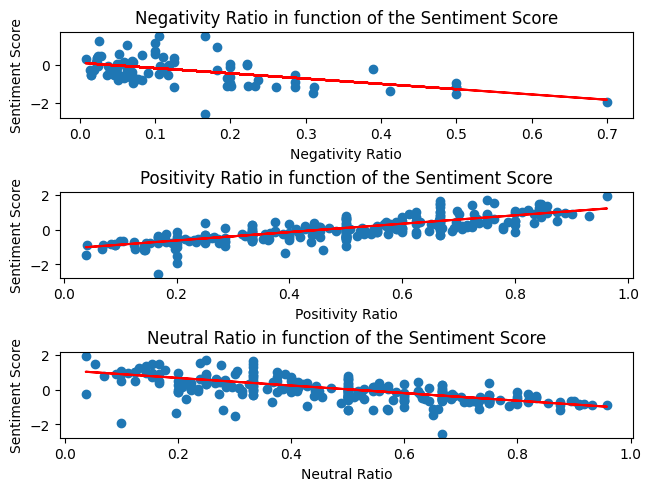

In [ ]:
z = np.polyfit(df["Negativity Ratio"], df["Sentiment Score Normalized"], 1)
p_neg = np.poly1d(z)

z2 = np.polyfit(df["Positivity Ratio"],df["Sentiment Score Normalized"], 1)
p_pos = np.poly1d(z2)

z3 = np.polyfit(df["Neutral Ratio"],df["Sentiment Score Normalized"], 1)
p_neu = np.poly1d(z3)

plt.figure(layout="constrained")
plt.subplot(3, 1, 1)
plt.xlabel('Negativity Ratio')
plt.ylabel('Sentiment Score')
plt.title('Negativity Ratio in function of the Sentiment Score')
plt.scatter(df_neg["Negativity Ratio"], df_neg["Sentiment Score Normalized"])
plt.plot(df_neg["Negativity Ratio"],p_neg(df_neg["Negativity Ratio"]), color="r")
plt.subplot(3, 1, 2)
plt.xlabel('Positivity Ratio')
plt.ylabel('Sentiment Score')
plt.title('Positivity Ratio in function of the Sentiment Score')
plt.scatter(df_pos["Positivity Ratio"],df_pos["Sentiment Score Normalized"])
plt.plot(df_pos["Positivity Ratio"],p_pos(df_pos["Positivity Ratio"]), color="r")
plt.subplot(3, 1, 3)
plt.xlabel('Neutral Ratio')
plt.ylabel('Sentiment Score')
plt.title('Neutral Ratio in function of the Sentiment Score')
plt.scatter(df_neu["Neutral Ratio"],df_neu["Sentiment Score Normalized"])
plt.plot(df_neu["Neutral Ratio"],p_neu(df_neu["Neutral Ratio"]), color="r")

plt.show()

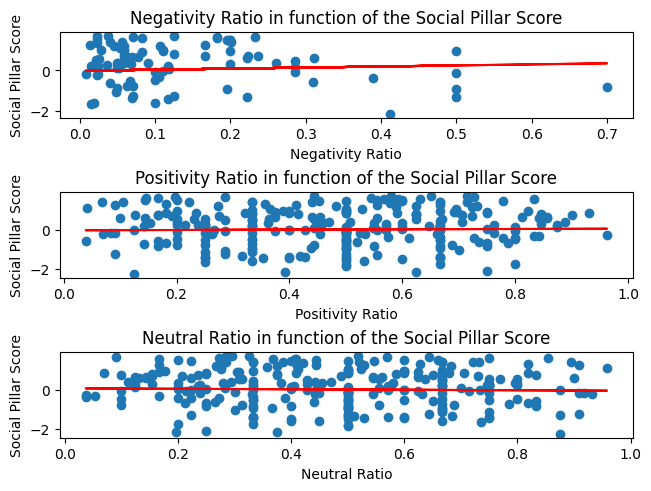

In [ ]:
z = np.polyfit(df["Negativity Ratio"], df["Social Pillar Score Normalized"], 1)
p_neg = np.poly1d(z)

z2 = np.polyfit(df["Positivity Ratio"],df["Social Pillar Score Normalized"], 1)
p_pos = np.poly1d(z2)

z3 = np.polyfit(df["Neutral Ratio"],df["Social Pillar Score Normalized"], 1)
p_neu = np.poly1d(z3)

plt.figure(layout="constrained")
plt.subplot(3, 1, 1)
plt.xlabel('Negativity Ratio')
plt.ylabel('Social Pillar Score')
plt.title('Negativity Ratio in function of the Social Pillar Score')
plt.scatter(df_neg["Negativity Ratio"], df_neg["Social Pillar Score Normalized"])
plt.plot(df_neg["Negativity Ratio"],p_neg(df_neg["Negativity Ratio"]), color="r")
plt.subplot(3, 1, 2)
plt.xlabel('Positivity Ratio')
plt.ylabel('Social Pillar Score')
plt.title('Positivity Ratio in function of the Social Pillar Score')
plt.scatter(df_pos["Positivity Ratio"],df_pos["Social Pillar Score Normalized"])
plt.plot(df_pos["Positivity Ratio"],p_pos(df_pos["Positivity Ratio"]), color="r")
plt.subplot(3, 1, 3)
plt.xlabel('Neutral Ratio')
plt.ylabel('Social Pillar Score')
plt.title('Neutral Ratio in function of the Social Pillar Score')
plt.scatter(df_neu["Neutral Ratio"],df_neu["Social Pillar Score Normalized"])
plt.plot(df_neu["Neutral Ratio"],p_neu(df_neu["Neutral Ratio"]), color="r")

plt.show()

In [ ]:
df[['Positivity Ratio', 'Negativity Ratio', 'Neutral Ratio', 'Sentiment Score Normalized','Social Pillar Score Normalized']].corr()

,Positivity Ratio,Negativity Ratio,Neutral Ratio,Sentiment Score Normalized,Social Pillar Score Normalized
Positivity Ratio,1.000000,-0.124896,-0.961004,0.836664,0.029453
Negativity Ratio,-0.124896,1.000000,-0.154344,-0.263023,0.050931
Neutral Ratio,-0.961004,-0.154344,1.000000,-0.759853,-0.043524
Sentiment Score Normalized,0.836664,-0.263023,-0.759853,1.000000,-0.021810
Social Pillar Score Normalized,0.029453,0.050931,-0.043524,-0.021810,1.000000


In [ ]:
pearson_results = []
kendall_results = []
combinations = [
    ('Positivity Ratio', 'Social Pillar Score Normalized'),
    ('Positivity Ratio', 'Sentiment Score Normalized'),
    ('Negativity Ratio', 'Social Pillar Score Normalized'),
    ('Negativity Ratio', 'Sentiment Score Normalized'),
    ('Neutral Ratio', 'Social Pillar Score Normalized'),
    ('Neutral Ratio', 'Sentiment Score Normalized'),
]

for var1, var2 in combinations:
    pearson_stat, pearson_p = stats.pearsonr(df[var1], df[var2])
    kendall_stat, kendall_p = stats.kendalltau(df[var1], df[var2])

    pearson_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Statistic': pearson_stat,
        'P-Value': pearson_p
    })

    kendall_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Statistic': kendall_stat,
        'P-Value': kendall_p
    })

pearson_results_df = pd.DataFrame(pearson_results)
kendall_results_df = pd.DataFrame(kendall_results)
kendall_results_df

,Variable 1,Variable 2,Statistic,P-Value
0,Positivity Ratio,Social Pillar Score Normalized,0.035718,2.943069e-01
1,Positivity Ratio,Sentiment Score Normalized,0.751126,8.626808e-106
2,Negativity Ratio,Social Pillar Score Normalized,0.122666,1.277307e-03
3,Negativity Ratio,Sentiment Score Normalized,-0.129131,7.831839e-04
4,Neutral Ratio,Social Pillar Score Normalized,-0.037517,2.700463e-01
5,Neutral Ratio,Sentiment Score Normalized,-0.676161,2.608053e-86


# 2. Filtered Dataset Analysis (excl. Co w/ less than 15 datapoints + 0 +ve and 0 -ve news)

Text(0.5, 1.0, 'Social Pillar Score in function of Sentiment Score (filtered Dataset)')

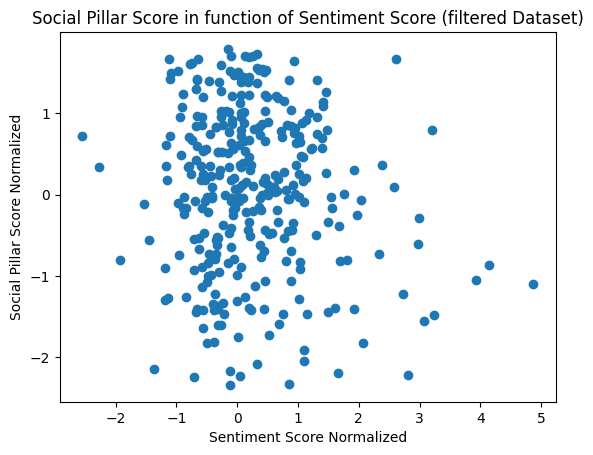

In [ ]:
df_out = df[(df['Positive'] == 0) & (df['Negative'] == 0) & (df['Datapoints'] <= 15)]
df_filtered = df[~df.isin(df_out).all(axis=1)]
plt.scatter(df_filtered['Sentiment Score Normalized'], df_filtered['Social Pillar Score Normalized'])
plt.xlabel('Sentiment Score Normalized')
plt.ylabel('Social Pillar Score Normalized')
plt.title('Social Pillar Score in function of Sentiment Score (filtered Dataset)')

In [ ]:
df_filtered.shape[0]

330

In [ ]:
df_filtered.groupby('Sector').agg(
    Number_of_Companies=('Sector', 'count'),
    Median_Datapoints=('Datapoints', 'median'))

,Number_of_Companies,Median_Datapoints
Sector,,
Food & Beverages,47,5.0
Insurance,127,7.0
Renewable Energy,22,6.5
Telecom,22,22.0
Textiles & Apparel,38,8.5
Transportation,74,8.5


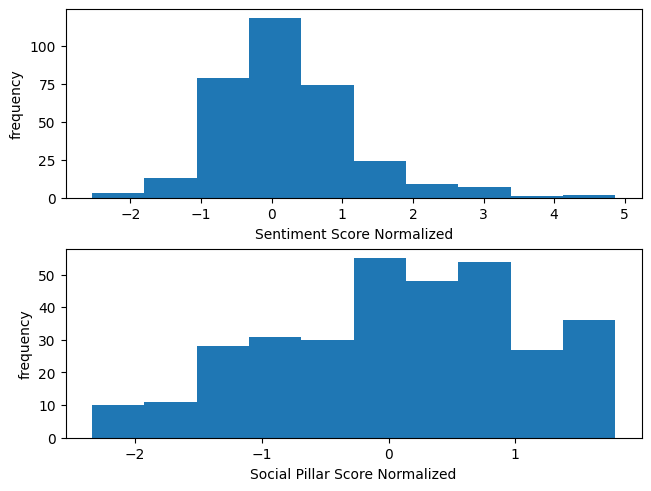

In [ ]:
#visulationsation of the data
plt.figure(layout="constrained")
plt.subplot(2, 1, 1)
plt.ylabel('frequency')
plt.xlabel('Sentiment Score Normalized')
plt.hist(df_filtered['Sentiment Score Normalized'])
plt.subplot(2, 1, 2)
plt.ylabel('frequency')
plt.xlabel('Social Pillar Score Normalized')
plt.hist(df_filtered['Social Pillar Score Normalized'])
plt.show()

In [ ]:
# Sentiment Score Normal Test
normaltest = stats.normaltest(df_filtered['Sentiment Score Normalized']).statistic
pvalue = stats.normaltest(df_filtered['Sentiment Score Normalized']).pvalue
skew = stats.skew(df_filtered['Sentiment Score Normalized'], axis=0, bias=True)
kurtosis = stats.kurtosis(df_filtered['Sentiment Score Normalized'], axis=0, bias=True)
print('test normal: %f (pvalue=%f) , skewness: %f , kurtosis: %f' % (normaltest, pvalue, skew, kurtosis))

test normal: 74.627380 (pvalue=0.000000) , skewness: 1.112099 , kurtosis: 2.751038


In [ ]:
# Social Pillar Score Normal Test
normaltest = stats.normaltest(df_filtered['Social Pillar Score Normalized']).statistic
pvalue = stats.normaltest(df_filtered['Social Pillar Score Normalized']).pvalue
skew = stats.skew(df_filtered['Social Pillar Score Normalized'], axis=0, bias=True)
kurtosis = stats.kurtosis(df_filtered['Social Pillar Score Normalized'], axis=0, bias=True)
print('test normal: %f (pvalue=%f) , skewness: %f , kurtosis: %f' % (normaltest, pvalue, skew, kurtosis))

test normal: 17.218666 (pvalue=0.000182) , skewness: -0.361646 , kurtosis: -0.615049


In [ ]:
personstat = stats.pearsonr(df_filtered['Sentiment Score Normalized'], df_filtered['Social Pillar Score Normalized']).statistic
personpvalue = stats.pearsonr(df_filtered['Sentiment Score Normalized'], df_filtered['Social Pillar Score Normalized']).pvalue
kendalltaustat = stats.kendalltau(df_filtered['Sentiment Score Normalized'], df_filtered['Social Pillar Score Normalized']).statistic
kendalltauvalue = stats.kendalltau(df_filtered['Sentiment Score Normalized'], df_filtered['Social Pillar Score Normalized']).pvalue

print('Pearson R Test: %f (pvalue=%f) , Kendall Tau Test: %f (pvalue=%f) ' % (personstat, personpvalue, kendalltaustat, kendalltauvalue))

Pearson R Test: -0.112078 (pvalue=0.041882) , Kendall Tau Test: -0.029161 (pvalue=0.429289) 


In [ ]:
stats.spearmanr(df_filtered['Sentiment Score Normalized'], df_filtered['Social Pillar Score Normalized'])

SignificanceResult(statistic=-0.04200974247359246, pvalue=0.44690501233873825)

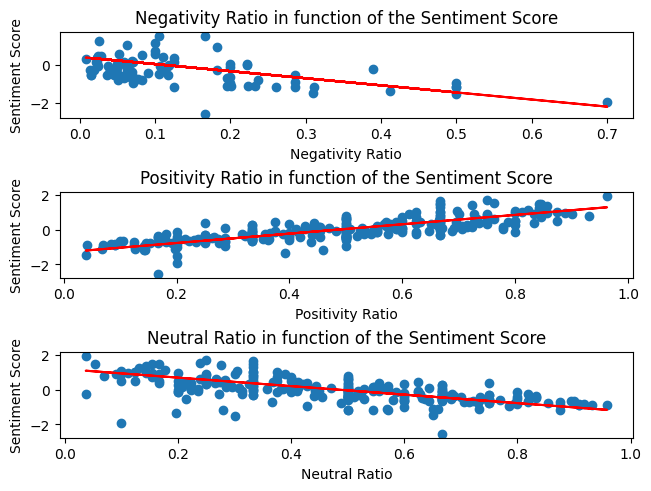

In [ ]:
z = np.polyfit(df_filtered["Negativity Ratio"], df_filtered["Sentiment Score Normalized"], 1)
p_neg = np.poly1d(z)

z2 = np.polyfit(df_filtered["Positivity Ratio"],df_filtered["Sentiment Score Normalized"], 1)
p_pos = np.poly1d(z2)

z3 = np.polyfit(df_filtered["Neutral Ratio"],df_filtered["Sentiment Score Normalized"], 1)
p_neu = np.poly1d(z3)

plt.figure(layout="constrained")
plt.subplot(3, 1, 1)
plt.xlabel('Negativity Ratio')
plt.ylabel('Sentiment Score')
plt.title('Negativity Ratio in function of the Sentiment Score')
plt.scatter(df_neg["Negativity Ratio"], df_neg["Sentiment Score Normalized"])
plt.plot(df_neg["Negativity Ratio"],p_neg(df_neg["Negativity Ratio"]), color="r")
plt.subplot(3, 1, 2)
plt.xlabel('Positivity Ratio')
plt.ylabel('Sentiment Score')
plt.title('Positivity Ratio in function of the Sentiment Score')
plt.scatter(df_pos["Positivity Ratio"],df_pos["Sentiment Score Normalized"])
plt.plot(df_pos["Positivity Ratio"],p_pos(df_pos["Positivity Ratio"]), color="r")
plt.subplot(3, 1, 3)
plt.xlabel('Neutral Ratio')
plt.ylabel('Sentiment Score')
plt.title('Neutral Ratio in function of the Sentiment Score')
plt.scatter(df_neu["Neutral Ratio"],df_neu["Sentiment Score Normalized"])
plt.plot(df_neu["Neutral Ratio"],p_neu(df_neu["Neutral Ratio"]), color="r")

plt.show()

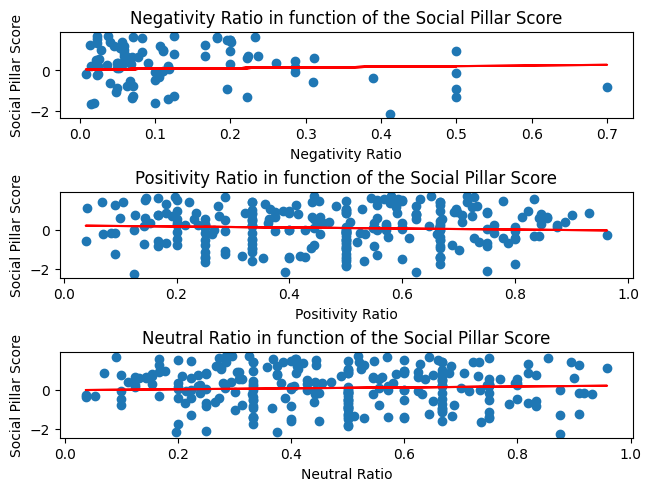

In [ ]:
z = np.polyfit(df_filtered["Negativity Ratio"], df_filtered["Social Pillar Score Normalized"], 1)
p_neg = np.poly1d(z)

z2 = np.polyfit(df_filtered["Positivity Ratio"],df_filtered["Social Pillar Score Normalized"], 1)
p_pos = np.poly1d(z2)

z3 = np.polyfit(df_filtered["Neutral Ratio"],df_filtered["Social Pillar Score Normalized"], 1)
p_neu = np.poly1d(z3)

plt.figure(layout="constrained")
plt.subplot(3, 1, 1)
plt.xlabel('Negativity Ratio')
plt.ylabel('Social Pillar Score')
plt.title('Negativity Ratio in function of the Social Pillar Score')
plt.scatter(df_neg["Negativity Ratio"], df_neg["Social Pillar Score Normalized"])
plt.plot(df_neg["Negativity Ratio"],p_neg(df_neg["Negativity Ratio"]), color="r")
plt.subplot(3, 1, 2)
plt.xlabel('Positivity Ratio')
plt.ylabel('Social Pillar Score')
plt.title('Positivity Ratio in function of the Social Pillar Score')
plt.scatter(df_pos["Positivity Ratio"],df_pos["Social Pillar Score Normalized"])
plt.plot(df_pos["Positivity Ratio"],p_pos(df_pos["Positivity Ratio"]), color="r")
plt.subplot(3, 1, 3)
plt.xlabel('Neutral Ratio')
plt.ylabel('Social Pillar Score')
plt.title('Neutral Ratio in function of the Social Pillar Score')
plt.scatter(df_neu["Neutral Ratio"],df_neu["Social Pillar Score Normalized"])
plt.plot(df_neu["Neutral Ratio"],p_neu(df_neu["Neutral Ratio"]), color="r")

plt.show()

In [ ]:
df_filtered[['Positivity Ratio', 'Negativity Ratio', 'Neutral Ratio', 'Sentiment Score Normalized','Social Pillar Score Normalized']].corr()

,Positivity Ratio,Negativity Ratio,Neutral Ratio,Sentiment Score Normalized,Social Pillar Score Normalized
Positivity Ratio,1.000000,-0.323261,-0.929262,0.796117,-0.074840
Negativity Ratio,-0.323261,1.000000,-0.049192,-0.398456,0.035538
Neutral Ratio,-0.929262,-0.049192,1.000000,-0.684718,0.065117
Sentiment Score Normalized,0.796117,-0.398456,-0.684718,1.000000,-0.112078
Social Pillar Score Normalized,-0.074840,0.035538,0.065117,-0.112078,1.000000


In [ ]:
pearson_results = []
kendall_results = []
combinations = [
    ('Positivity Ratio', 'Social Pillar Score Normalized'),
    ('Positivity Ratio', 'Sentiment Score Normalized'),
    ('Negativity Ratio', 'Social Pillar Score Normalized'),
    ('Negativity Ratio', 'Sentiment Score Normalized'),
    ('Neutral Ratio', 'Social Pillar Score Normalized'),
    ('Neutral Ratio', 'Sentiment Score Normalized'),
]

for var1, var2 in combinations:
    pearson_stat, pearson_p = stats.pearsonr(df_filtered[var1], df_filtered[var2])
    kendall_stat, kendall_p = stats.kendalltau(df_filtered[var1], df_filtered[var2])

    pearson_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Statistic': pearson_stat,
        'P-Value': pearson_p
    })

    kendall_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Statistic': kendall_stat,
        'P-Value': kendall_p
    })

pearson_results_df = pd.DataFrame(pearson_results)
kendall_results_df = pd.DataFrame(kendall_results)
kendall_results_df

,Variable 1,Variable 2,Statistic,P-Value
0,Positivity Ratio,Social Pillar Score Normalized,-0.036041,3.400462e-01
1,Positivity Ratio,Sentiment Score Normalized,0.692712,4.195020e-75
2,Negativity Ratio,Social Pillar Score Normalized,0.112312,7.624655e-03
3,Negativity Ratio,Sentiment Score Normalized,-0.307945,2.556680e-13
4,Neutral Ratio,Social Pillar Score Normalized,0.030812,4.148131e-01
5,Neutral Ratio,Sentiment Score Normalized,-0.585771,3.329473e-54
